<a href="https://colab.research.google.com/github/smomtahe/GAN_DenseNeuralNetwork./blob/main/GAN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [217]:
# Generative Adversarial Networks
import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import layers
from tensorflow.keras.layers import Add, Dense, ReLU, Reshape, LeakyReLU


In [218]:
(train_images,_), (_,_)=tf.keras.datasets.fashion_mnist.load_data()
train_images.shape  #(60000, 28, 28) - batch size 60000 height width # channels:1(gray):every pixel represents pixel intensity (0-255) #NN works with baches of imgs 3D with # of channels


(60000, 28, 28)

In [219]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images.shape # (60000, 28, 28, 1)
train_images[56782,:10,:10] # a sample 0-255 -> recenter all images at zero (127.5)


array([[[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  1.],
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [  0.],
        [ 74.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [  0.],
        [ 77.],
        [207.]],

       [[  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [124.],
        [176.],
        [192.],
        [180.]],

       [[  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [ 88.],
        [207.],
        [184.],
        [183.],
        [182.]],

       [[  0.],
        [  0

In [220]:
train_images=(train_images-127.5)/127.5 #  -1 to 1 to represent img-> fake imgs by generator will have pixel value in this range
train_images[56782,:10,:10]


array([[[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.41960785]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.39607844],
        [ 0.62352943]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
   

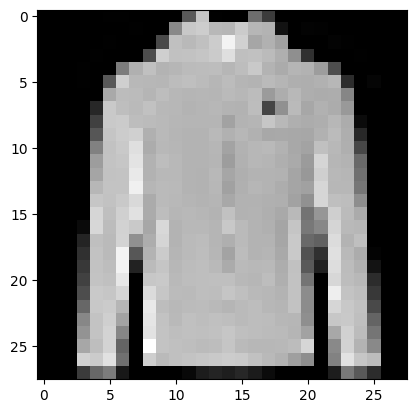

In [221]:
plt.imshow(train_images[56782].squeeze(),cmap='gray')


In [222]:
buffer_size=60000 #shuffle imgs
batch_size=128
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [223]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, ReLU, Reshape

def generator_model():
    model = tf.keras.Sequential()

    # First hidden layer
    model.add(Dense(64, input_dim=100))
    model.add(ReLU())

    # Second hidden layer
    model.add(Dense(128))
    model.add(ReLU())

    # Third hidden layer
    model.add(Dense(256))
    model.add(ReLU())

    # Output layer - size 784 pixels (=28*28)
    # Activation 'tanh' produces outputs in the range -1 to 1 (same range as the images in the real dataset)
    model.add(Dense(784, activation='tanh'))

    # Generator produces realistic images: flatten 784 pixels of our generator image
    # Reshape to be the same as a real image
    model.add(Reshape((28, 28, 1)))

    return model

generator = generator_model()
generator.summary()


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 64)                6464      
                                                                 
 re_lu_15 (ReLU)             (None, 64)                0         
                                                                 
 dense_60 (Dense)            (None, 128)               8320      
                                                                 
 re_lu_16 (ReLU)             (None, 128)               0         
                                                                 
 dense_61 (Dense)            (None, 256)               33024     
                                                                 
 re_lu_17 (ReLU)             (None, 256)               0         
                                                                 
 dense_62 (Dense)            (None, 784)             

In [224]:
# generate a noise variable vector to feed in the generator model
noise=tf.random.normal([1,100])  # generate Gaussian noise: vector size is 100= input dimension of our generator model
generated_image=generator(noise,training=False)  # False: see the generated img looks like
generated_image.shape  # TensorShape([1, 28, 28, 1]) 1 img batch size 1 - 28*28 1 chanel

TensorShape([1, 28, 28, 1])

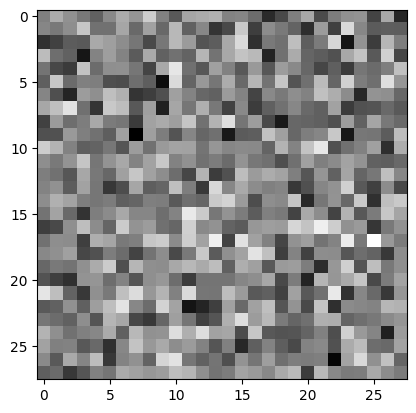

In [225]:
# plot generated img (generator has not trained yet)
plt.imshow(generated_image[0,:,:,0],cmap="gray")


In [226]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(28,28,1)))
    model.add(layers.Flatten()) # flatten input img: imgs represented as a single dimensional vector : passed in the dense layers
    # 3 Dense layers
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2)) # slight gradient for input values below zero : controlled by the input argument (o.2) that we pass into LR
    model.add(layers.Dropout(0.5)) # dropout: overfitting : turning off a % of neurons in the layer

    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation='sigmoid')) # single probability score: represent the prob that input img is real -sigmoid : prob score : 0-1

    return model
# input img fed into real or fake

In [227]:
discriminator=discriminator_model()
discriminator.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_63 (Dense)            (None, 256)               200960    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_64 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 128)               0         
                                                                 
 dropout_25 (Dropout)        (None, 128)             

In [228]:
discriminator=discriminator_model()
output=discriminator(generated_image)
print(output)
# img (noise) from untrained generated model and pass this through the untrained discriminator ->  probability score: % 49

tf.Tensor([[0.5340168]], shape=(1, 1), dtype=float32)


In [229]:
bce=tf.keras.losses.BinaryCrossentropy()  # loss function

In [230]:
def discriminator_loss(real_output,fake_output):
  # 2 classes 1: real and 0:fake # imgs from real dataset classfied as real
  real_loss=bce(tf.ones_like(real_output),real_output) # compare output of discriminator to a tensor of 1s, this loss = real loss of the discriminator
  fake_loss=bce(tf.zeros_like(fake_output),fake_output) # tensor of 0s #fake binary crossentropy loss
  total_loss=real_loss+fake_loss # try to min total loss or max probabilty real imgs classifed as real and generated imgs are classfied as fake
  return total_loss


In [231]:
# Traning GANs # 2 Networks
# generator loss
def generator_loss(fake_output):
  gen_loss=bce(tf.ones_like(fake_output),fake_output) # input is fake_output = output of discriminator for fake data generated by the generator & compare the output to a tensor of all 1s
  # objective: fools discriminator: classifies fake data as real
  return gen_loss

In [232]:
# optimizers for both # Adam preforms gredient descent using an exponentially weighted average of gradients
generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

In [233]:
# training  # interrupt start from the last checkpoint
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Specify the directory to save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')

# Create a tf.train.Checkpoint object
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [234]:
# training process
epochs=50
noise_dim=100
num_examples_to_generate=16 # after epoch of training , generate 16 examples from our GAN to see that what the generated images looked like; these 10 images generated usign 16 different noise vectors, each dimensionality 100

seed=tf.random.normal([num_examples_to_generate,noise_dim])

In [235]:
@tf.function() #python animation as a transformation tool & creates data flow graphs out of ur Py code # generate NN graph
def train_step(images):  # images as input
  noise=tf.random.normal([batch_size,noise_dim]) # @ every step generate a batch of noise
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # GradientTape : gradient descent -> train NN - 2 types of NN
    generated_images=generator(noise,training=True) #generate fake images from generator -> trainign true

    real_output=discriminator(images,training=True) # train discriminator : real and fake images
    fake_output=discriminator(generated_images,training=True)

    disc_loss=discriminator_loss(real_output,fake_output)
    gen_loss=generator_loss(fake_output)

  gradient_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradient_of_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

  return(gen_loss,disc_loss,tf.reduce_mean(real_output),tf.reduce_mean(fake_output))
  # return losses and accuracy of discriminator on real data and fake data

In [236]:
# helper function generate & plot images to get the generator to generate images form the test input that we have specified
def generate_and_plot_images(model,epoch,test_input):
  predictions=model(test_input,training=False) # output of generator for test noise input that we set up earlier
  fig=plt.figure(figsize=(8,4)) # plot this output to see how the generator improves over time

  for i in range (predictions.shape[0]):
    plt.subplot(4,4,i+1)
    pred=(predictions[i,:,:,0]+1)*127.5
    pred=np.array(pred)
    plt.imshow(pred.astype(np.uint8),cmap='gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [237]:
# actual training
def train(dataset,epochs):
  gen_loss_list=[]
  disc_loss_list=[] # for plotting
  real_score_list=[]
  fake_score_list=[] # accuracy

  for epoch in tqdm(range(epochs)):
    start=time.time()
    num_batches=len(dataset)

    print(f'Training started with epochs {epoch+1} with {num_batches} bateches...')

    total_gen_loss=0
    total_disc_loss=0

    for batch in dataset:
      generator_loss, discriminator_loss,real_score, fake_score=train_step(batch)
      total_gen_loss+=generator_loss
      total_disc_loss+=discriminator_loss

    mean_gen_loss=total_gen_loss/num_batches # average loss for epoch
    mean_disc_loss=total_disc_loss/num_batches

    print(f'Losses after epoch %5d: generator %.3f, discriminator %.3f,  real_score %.2f%%, fake_score %.2f%%' %
      (epoch+1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

    generate_and_plot_images(generator, epoch+1,seed)

    gen_loss_list.append(mean_gen_loss)
    disc_loss_list.append(mean_disc_loss)
    real_score_list.append(real_score)  # accuracy
    fake_score_list.append(fake_score)

    if (epoch+1)%10==0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

  return gen_loss_list, disc_loss_list,real_score_list,fake_score_list


  0%|          | 0/50 [00:00<?, ?it/s]

Training started with epochs 1 with 469 bateches...
Losses after epoch     1: generator 4.372, discriminator 0.385,  real_score 86.11%, fake_score 11.97%


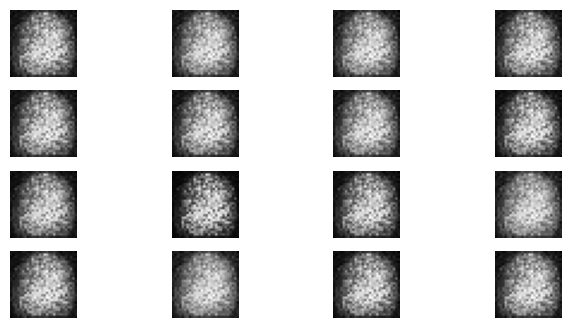

  2%|▏         | 1/50 [00:15<12:39, 15.50s/it]

Time for epoch 1 is 15.49964165687561 sec
Training started with epochs 2 with 469 bateches...
Losses after epoch     2: generator 3.858, discriminator 0.464,  real_score 83.54%, fake_score 10.61%


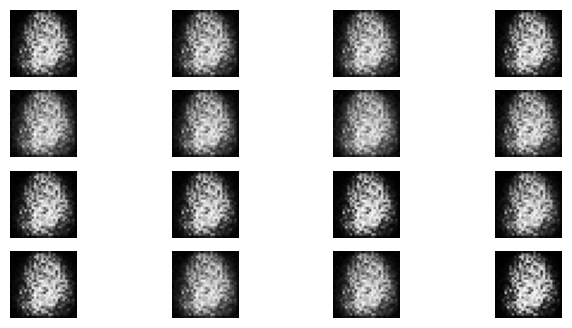

  4%|▍         | 2/50 [00:25<09:35, 11.98s/it]

Time for epoch 2 is 9.511702299118042 sec
Training started with epochs 3 with 469 bateches...
Losses after epoch     3: generator 3.496, discriminator 0.373,  real_score 91.32%, fake_score 11.57%


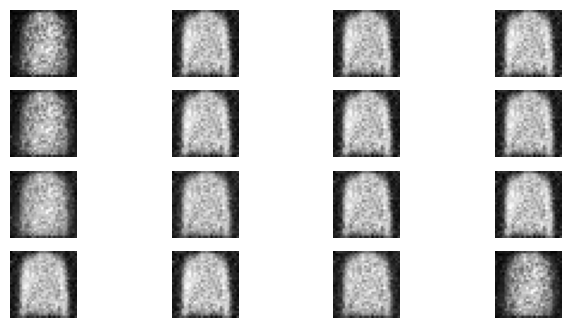

  6%|▌         | 3/50 [00:37<09:29, 12.12s/it]

Time for epoch 3 is 12.279664754867554 sec
Training started with epochs 4 with 469 bateches...
Losses after epoch     4: generator 3.412, discriminator 0.700,  real_score 82.56%, fake_score 11.46%


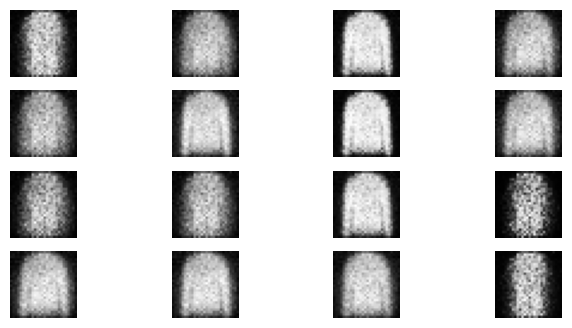

  8%|▊         | 4/50 [00:49<09:17, 12.12s/it]

Time for epoch 4 is 12.100619792938232 sec
Training started with epochs 5 with 469 bateches...
Losses after epoch     5: generator 2.832, discriminator 0.222,  real_score 93.73%, fake_score 8.68%


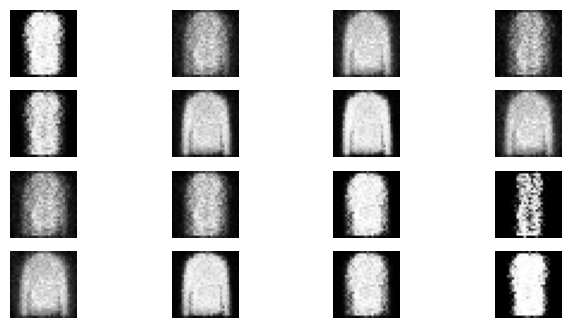

 10%|█         | 5/50 [01:00<08:49, 11.76s/it]

Time for epoch 5 is 11.11794924736023 sec
Training started with epochs 6 with 469 bateches...
Losses after epoch     6: generator 3.366, discriminator 0.523,  real_score 83.51%, fake_score 5.57%


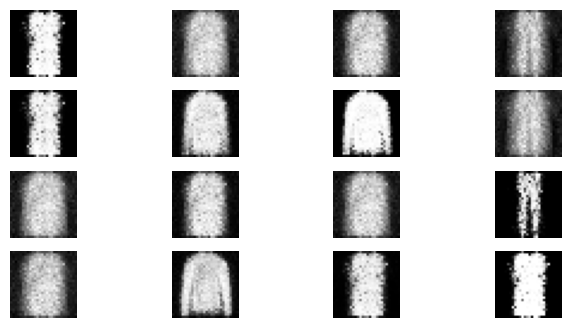

 12%|█▏        | 6/50 [01:11<08:22, 11.41s/it]

Time for epoch 6 is 10.732850551605225 sec
Training started with epochs 7 with 469 bateches...
Losses after epoch     7: generator 3.247, discriminator 0.256,  real_score 94.82%, fake_score 11.46%


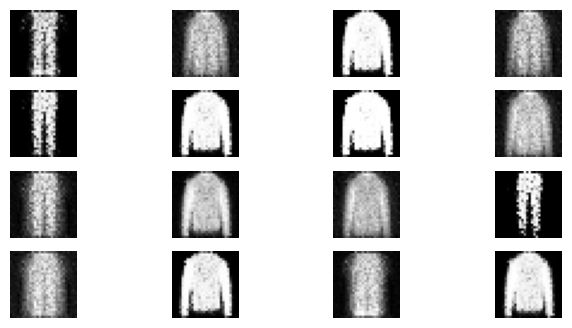

 14%|█▍        | 7/50 [01:21<07:58, 11.12s/it]

Time for epoch 7 is 10.518667459487915 sec
Training started with epochs 8 with 469 bateches...
Losses after epoch     8: generator 2.296, discriminator 0.434,  real_score 93.66%, fake_score 17.76%


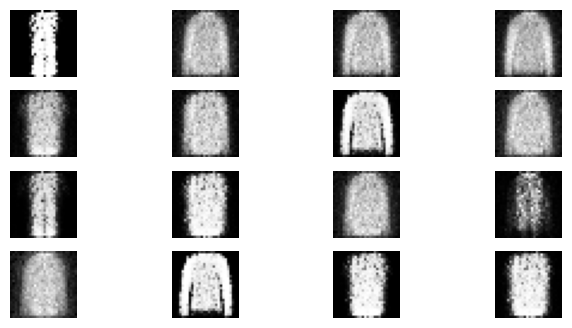

 16%|█▌        | 8/50 [01:32<07:38, 10.91s/it]

Time for epoch 8 is 10.449984550476074 sec
Training started with epochs 9 with 469 bateches...
Losses after epoch     9: generator 3.166, discriminator 0.570,  real_score 86.24%, fake_score 11.09%


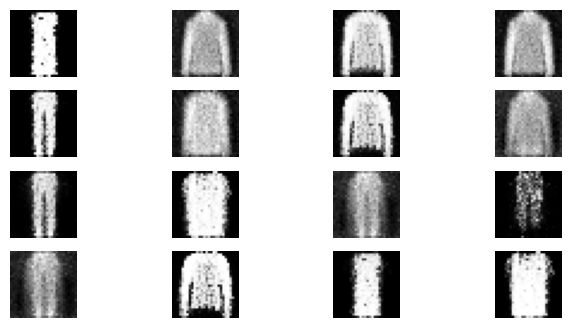

 18%|█▊        | 9/50 [01:42<07:19, 10.72s/it]

Time for epoch 9 is 10.313672304153442 sec
Training started with epochs 10 with 469 bateches...
Losses after epoch    10: generator 3.509, discriminator 0.632,  real_score 77.68%, fake_score 9.92%


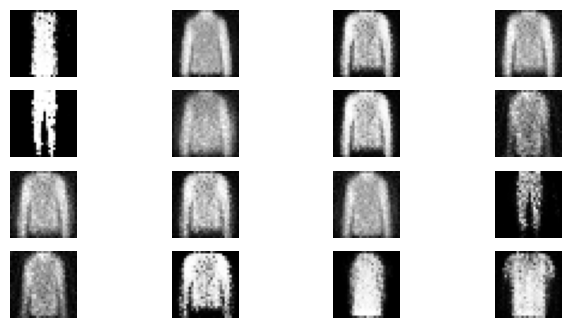

 20%|██        | 10/50 [01:52<07:00, 10.51s/it]

Time for epoch 10 is 10.013988494873047 sec
Training started with epochs 11 with 469 bateches...
Losses after epoch    11: generator 2.737, discriminator 0.406,  real_score 85.90%, fake_score 12.80%


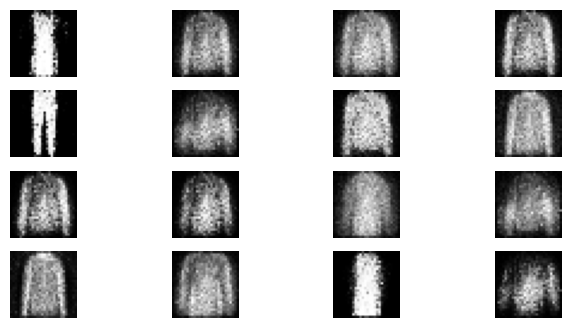

 22%|██▏       | 11/50 [02:02<06:46, 10.42s/it]

Time for epoch 11 is 10.213703155517578 sec
Training started with epochs 12 with 469 bateches...
Losses after epoch    12: generator 1.596, discriminator 0.872,  real_score 81.33%, fake_score 28.09%


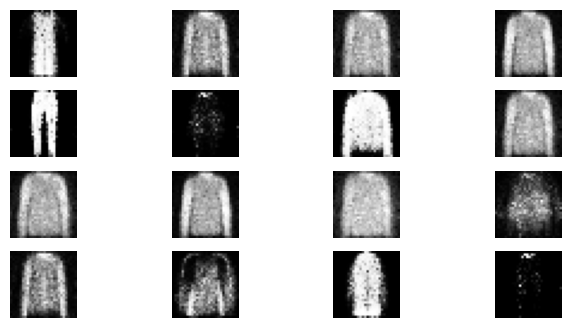

 24%|██▍       | 12/50 [02:13<06:34, 10.38s/it]

Time for epoch 12 is 10.300767421722412 sec
Training started with epochs 13 with 469 bateches...
Losses after epoch    13: generator 2.381, discriminator 0.362,  real_score 90.83%, fake_score 15.51%


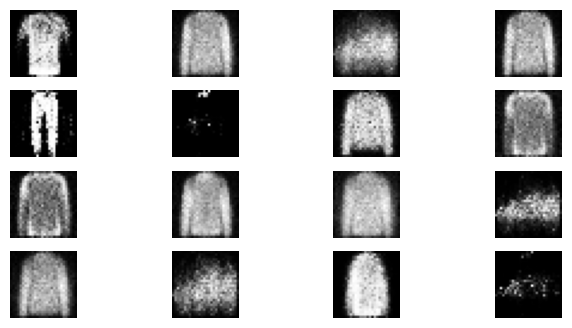

 26%|██▌       | 13/50 [02:24<06:35, 10.70s/it]

Time for epoch 13 is 11.408369302749634 sec
Training started with epochs 14 with 469 bateches...
Losses after epoch    14: generator 2.096, discriminator 0.676,  real_score 84.06%, fake_score 23.01%


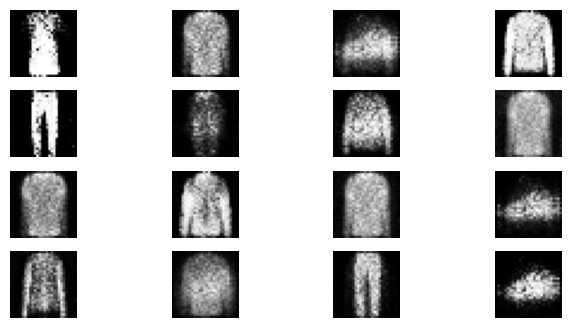

 28%|██▊       | 14/50 [02:34<06:19, 10.55s/it]

Time for epoch 14 is 10.208504438400269 sec
Training started with epochs 15 with 469 bateches...
Losses after epoch    15: generator 1.732, discriminator 1.042,  real_score 67.24%, fake_score 26.97%


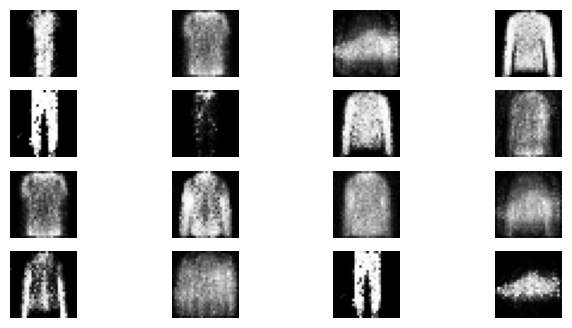

 30%|███       | 15/50 [02:45<06:12, 10.63s/it]

Time for epoch 15 is 10.821844100952148 sec
Training started with epochs 16 with 469 bateches...
Losses after epoch    16: generator 2.839, discriminator 0.427,  real_score 86.79%, fake_score 13.75%


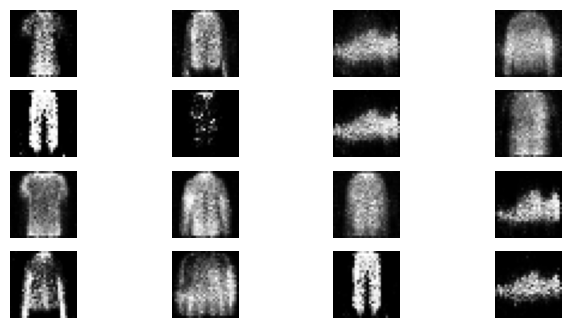

 32%|███▏      | 16/50 [02:55<05:56, 10.47s/it]

Time for epoch 16 is 10.08846378326416 sec
Training started with epochs 17 with 469 bateches...
Losses after epoch    17: generator 2.375, discriminator 0.854,  real_score 73.67%, fake_score 16.77%


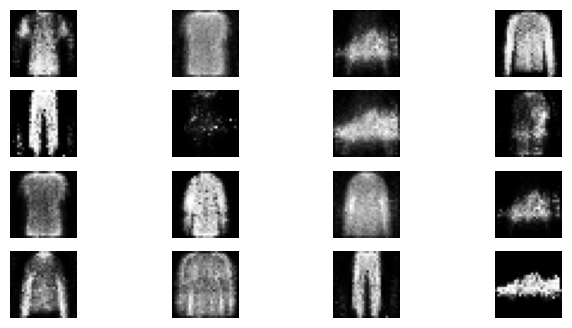

 34%|███▍      | 17/50 [03:05<05:42, 10.37s/it]

Time for epoch 17 is 10.143108606338501 sec
Training started with epochs 18 with 469 bateches...
Losses after epoch    18: generator 1.687, discriminator 0.923,  real_score 76.25%, fake_score 30.19%


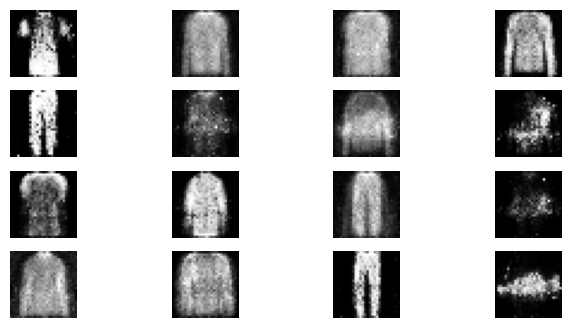

 36%|███▌      | 18/50 [03:17<05:43, 10.75s/it]

Time for epoch 18 is 11.613483905792236 sec
Training started with epochs 19 with 469 bateches...
Losses after epoch    19: generator 2.774, discriminator 0.544,  real_score 82.02%, fake_score 14.09%


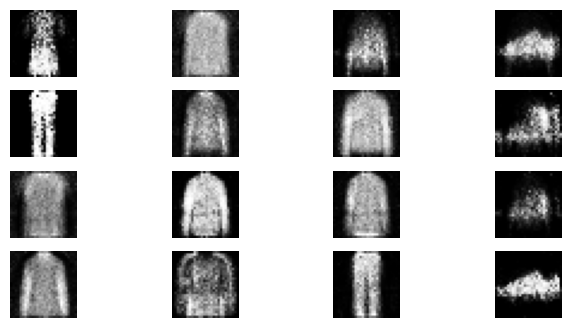

 38%|███▊      | 19/50 [03:28<05:32, 10.73s/it]

Time for epoch 19 is 10.701163530349731 sec
Training started with epochs 20 with 469 bateches...
Losses after epoch    20: generator 1.757, discriminator 1.040,  real_score 75.06%, fake_score 31.40%


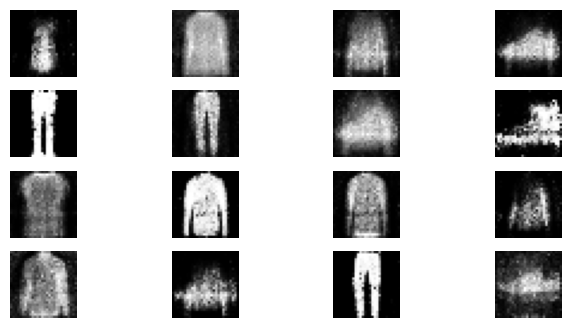

 40%|████      | 20/50 [03:39<05:28, 10.94s/it]

Time for epoch 20 is 11.402822494506836 sec
Training started with epochs 21 with 469 bateches...
Losses after epoch    21: generator 2.598, discriminator 0.479,  real_score 91.42%, fake_score 18.99%


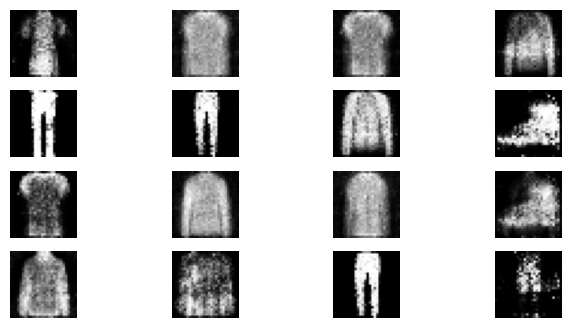

 42%|████▏     | 21/50 [03:50<05:17, 10.94s/it]

Time for epoch 21 is 10.942768335342407 sec
Training started with epochs 22 with 469 bateches...
Losses after epoch    22: generator 1.682, discriminator 1.044,  real_score 74.85%, fake_score 31.25%


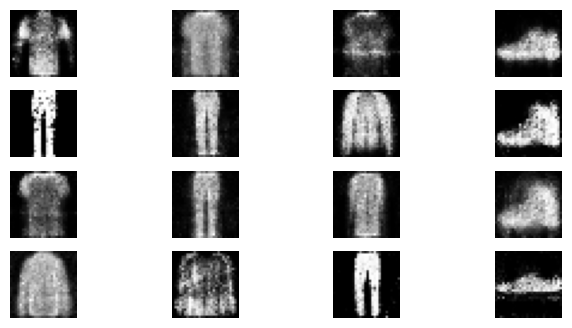

 44%|████▍     | 22/50 [04:01<05:05, 10.91s/it]

Time for epoch 22 is 10.823999643325806 sec
Training started with epochs 23 with 469 bateches...
Losses after epoch    23: generator 2.240, discriminator 0.807,  real_score 78.47%, fake_score 23.40%


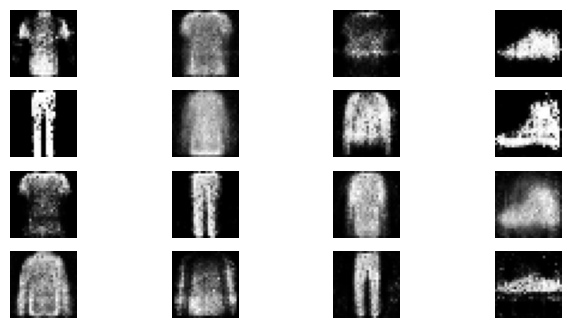

 46%|████▌     | 23/50 [04:11<04:48, 10.68s/it]

Time for epoch 23 is 10.142321825027466 sec
Training started with epochs 24 with 469 bateches...
Losses after epoch    24: generator 2.342, discriminator 0.752,  real_score 70.95%, fake_score 16.53%


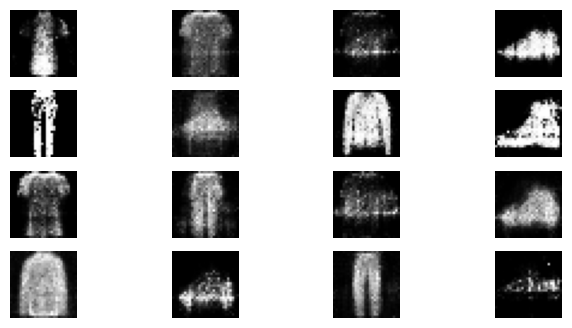

 48%|████▊     | 24/50 [04:21<04:31, 10.44s/it]

Time for epoch 24 is 9.883244752883911 sec
Training started with epochs 25 with 469 bateches...
Losses after epoch    25: generator 1.519, discriminator 1.088,  real_score 75.60%, fake_score 34.00%


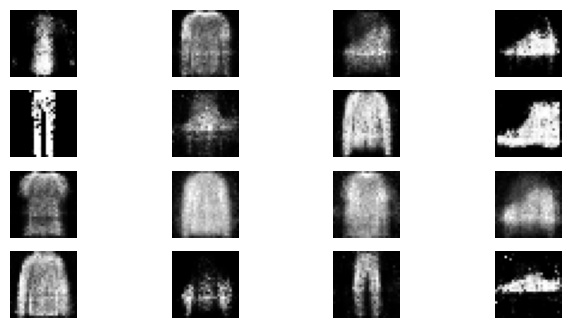

 50%|█████     | 25/50 [04:32<04:24, 10.60s/it]

Time for epoch 25 is 10.954971075057983 sec
Training started with epochs 26 with 469 bateches...
Losses after epoch    26: generator 1.784, discriminator 0.696,  real_score 84.43%, fake_score 27.05%


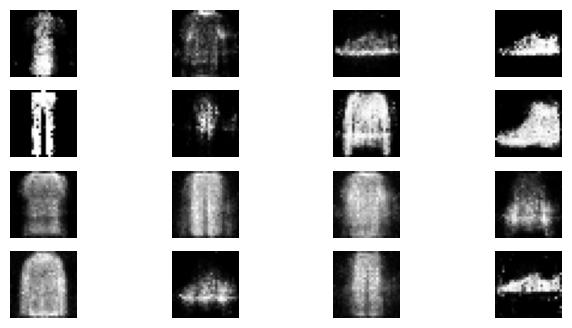

 52%|█████▏    | 26/50 [04:43<04:17, 10.75s/it]

Time for epoch 26 is 11.089892148971558 sec
Training started with epochs 27 with 469 bateches...
Losses after epoch    27: generator 3.082, discriminator 0.524,  real_score 84.55%, fake_score 15.71%


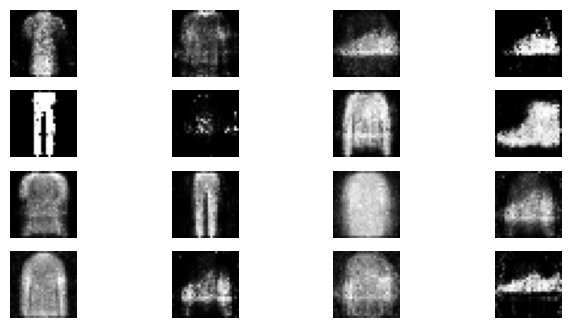

 54%|█████▍    | 27/50 [04:54<04:10, 10.87s/it]

Time for epoch 27 is 11.172525405883789 sec
Training started with epochs 28 with 469 bateches...
Losses after epoch    28: generator 2.275, discriminator 0.639,  real_score 77.53%, fake_score 17.37%


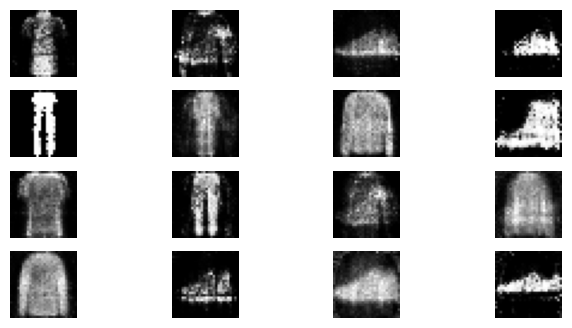

 56%|█████▌    | 28/50 [05:05<03:59, 10.90s/it]

Time for epoch 28 is 10.933334827423096 sec
Training started with epochs 29 with 469 bateches...
Losses after epoch    29: generator 3.085, discriminator 0.368,  real_score 83.31%, fake_score 9.17%


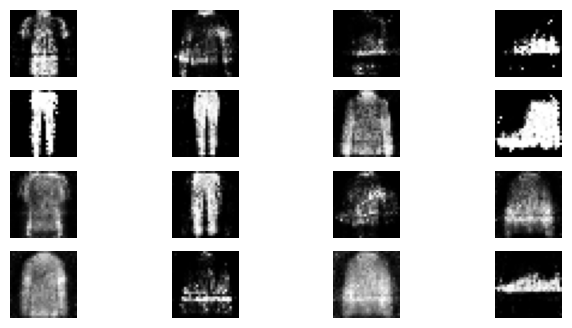

 58%|█████▊    | 29/50 [05:16<03:47, 10.85s/it]

Time for epoch 29 is 10.752075672149658 sec
Training started with epochs 30 with 469 bateches...
Losses after epoch    30: generator 2.214, discriminator 0.799,  real_score 74.05%, fake_score 18.92%


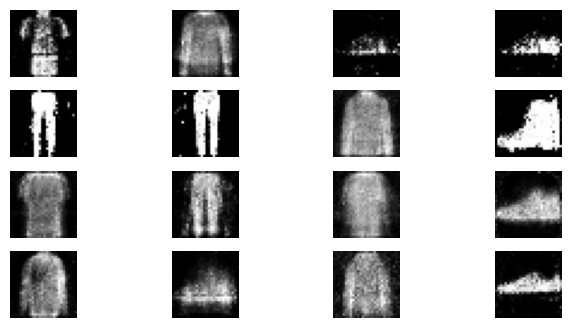

 60%|██████    | 30/50 [05:26<03:35, 10.80s/it]

Time for epoch 30 is 10.651132345199585 sec
Training started with epochs 31 with 469 bateches...
Losses after epoch    31: generator 2.022, discriminator 0.474,  real_score 83.27%, fake_score 18.90%


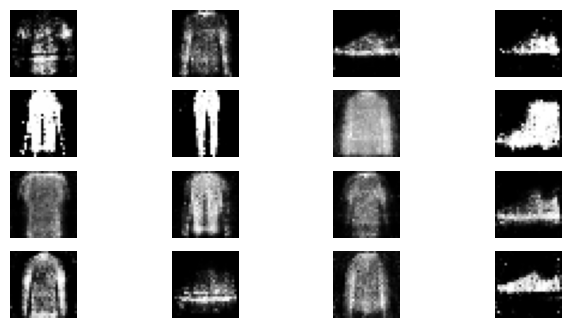

 62%|██████▏   | 31/50 [05:36<03:20, 10.55s/it]

Time for epoch 31 is 9.966896533966064 sec
Training started with epochs 32 with 469 bateches...
Losses after epoch    32: generator 2.605, discriminator 0.535,  real_score 80.95%, fake_score 14.52%


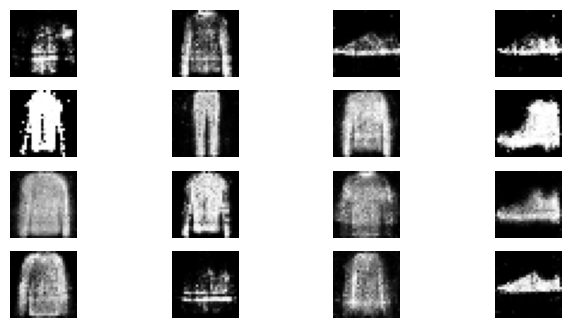

 64%|██████▍   | 32/50 [05:47<03:11, 10.64s/it]

Time for epoch 32 is 10.86737608909607 sec
Training started with epochs 33 with 469 bateches...
Losses after epoch    33: generator 2.497, discriminator 0.828,  real_score 82.09%, fake_score 23.01%


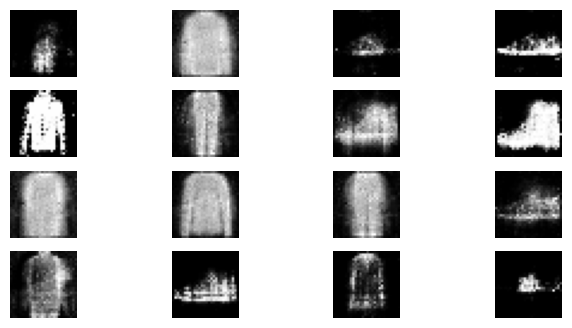

 66%|██████▌   | 33/50 [05:58<03:03, 10.79s/it]

Time for epoch 33 is 11.122734069824219 sec
Training started with epochs 34 with 469 bateches...
Losses after epoch    34: generator 1.390, discriminator 1.146,  real_score 67.64%, fake_score 33.81%


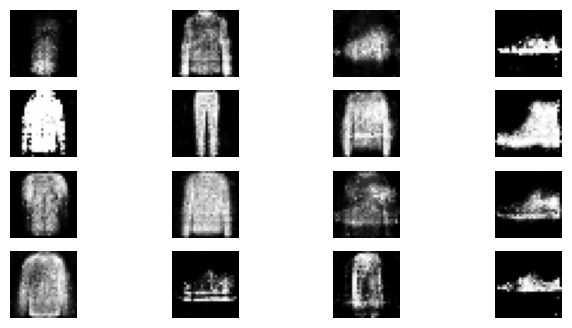

 68%|██████▊   | 34/50 [06:09<02:51, 10.73s/it]

Time for epoch 34 is 10.582594633102417 sec
Training started with epochs 35 with 469 bateches...
Losses after epoch    35: generator 2.297, discriminator 0.652,  real_score 82.58%, fake_score 20.23%


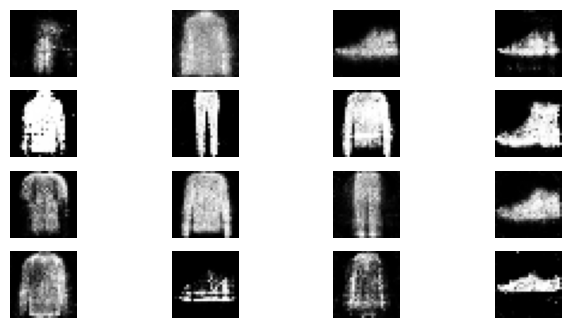

 70%|███████   | 35/50 [06:20<02:43, 10.89s/it]

Time for epoch 35 is 11.252729415893555 sec
Training started with epochs 36 with 469 bateches...
Losses after epoch    36: generator 1.589, discriminator 0.918,  real_score 75.85%, fake_score 28.80%


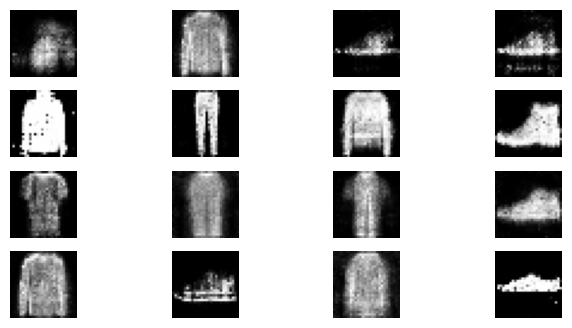

 72%|███████▏  | 36/50 [06:31<02:31, 10.82s/it]

Time for epoch 36 is 10.656530618667603 sec
Training started with epochs 37 with 469 bateches...
Losses after epoch    37: generator 2.476, discriminator 0.669,  real_score 80.54%, fake_score 21.99%


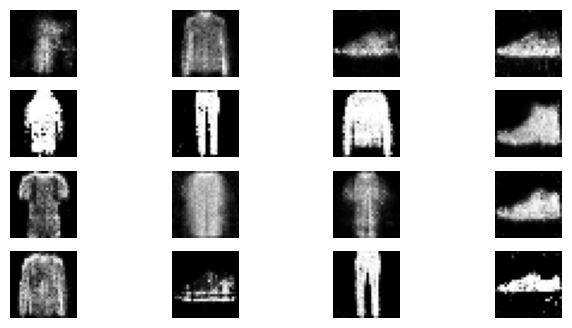

 74%|███████▍  | 37/50 [06:41<02:15, 10.45s/it]

Time for epoch 37 is 9.590449333190918 sec
Training started with epochs 38 with 469 bateches...
Losses after epoch    38: generator 1.834, discriminator 0.570,  real_score 81.18%, fake_score 22.44%


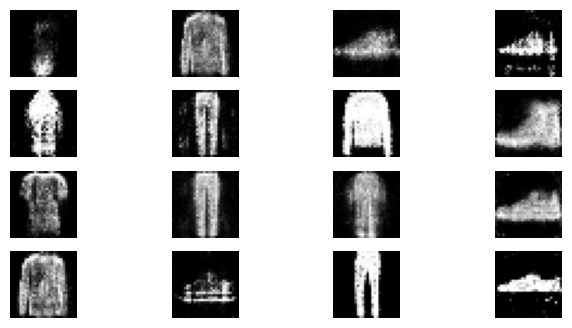

 76%|███████▌  | 38/50 [06:51<02:06, 10.58s/it]

Time for epoch 38 is 10.88411283493042 sec
Training started with epochs 39 with 469 bateches...
Losses after epoch    39: generator 2.654, discriminator 0.638,  real_score 77.10%, fake_score 17.04%


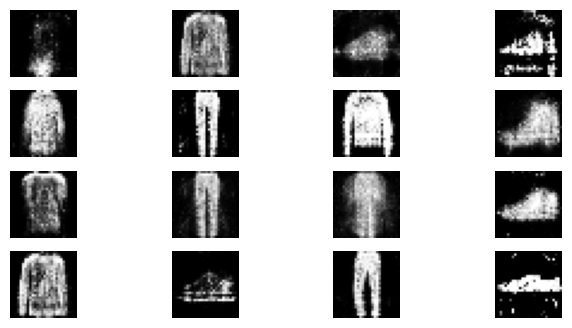

 78%|███████▊  | 39/50 [07:02<01:57, 10.67s/it]

Time for epoch 39 is 10.862899541854858 sec
Training started with epochs 40 with 469 bateches...
Losses after epoch    40: generator 3.279, discriminator 0.454,  real_score 85.76%, fake_score 14.09%


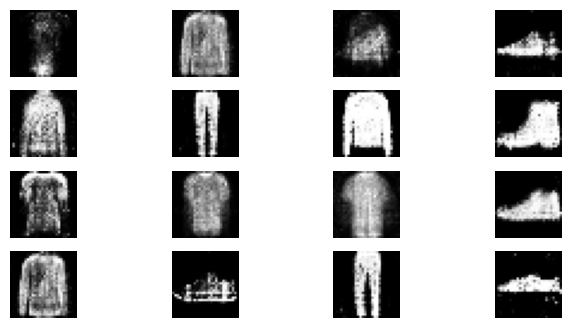

 80%|████████  | 40/50 [07:14<01:49, 10.95s/it]

Time for epoch 40 is 11.586849212646484 sec
Training started with epochs 41 with 469 bateches...
Losses after epoch    41: generator 2.164, discriminator 0.750,  real_score 82.44%, fake_score 24.00%


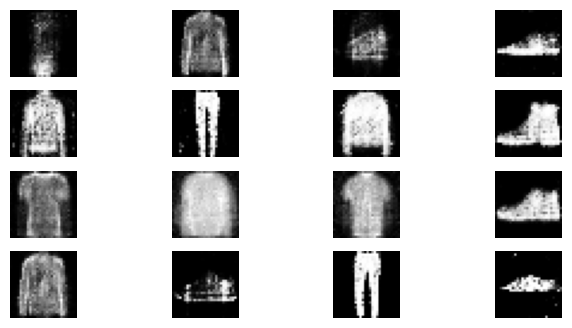

 82%|████████▏ | 41/50 [07:25<01:38, 10.91s/it]

Time for epoch 41 is 10.815717458724976 sec
Training started with epochs 42 with 469 bateches...
Losses after epoch    42: generator 1.578, discriminator 1.137,  real_score 68.75%, fake_score 29.86%


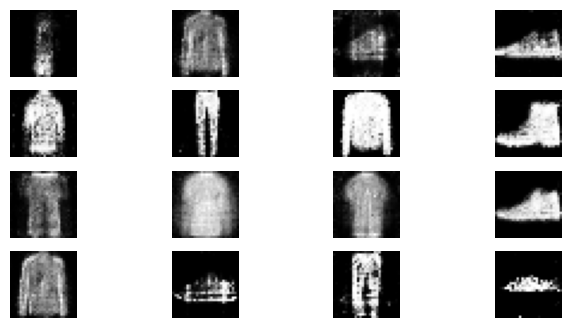

 84%|████████▍ | 42/50 [07:35<01:26, 10.85s/it]

Time for epoch 42 is 10.712759256362915 sec
Training started with epochs 43 with 469 bateches...
Losses after epoch    43: generator 1.600, discriminator 1.398,  real_score 56.33%, fake_score 31.29%


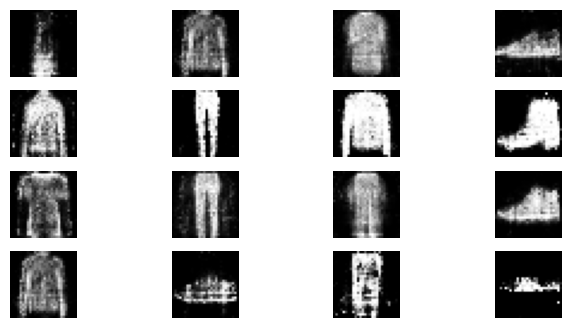

 86%|████████▌ | 43/50 [07:46<01:15, 10.82s/it]

Time for epoch 43 is 10.741278886795044 sec
Training started with epochs 44 with 469 bateches...
Losses after epoch    44: generator 1.470, discriminator 1.070,  real_score 71.20%, fake_score 34.90%


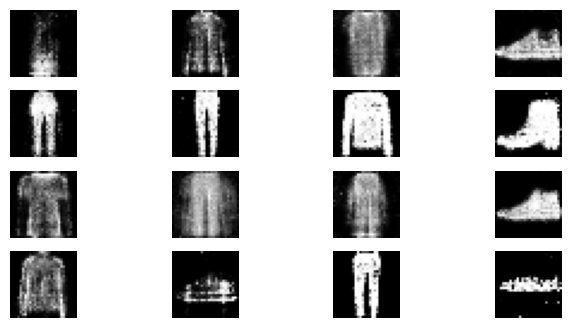

 88%|████████▊ | 44/50 [07:56<01:03, 10.58s/it]

Time for epoch 44 is 10.01055645942688 sec
Training started with epochs 45 with 469 bateches...
Losses after epoch    45: generator 1.620, discriminator 1.118,  real_score 61.84%, fake_score 27.62%


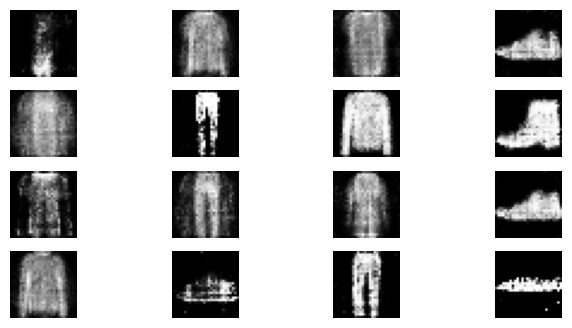

 90%|█████████ | 45/50 [08:07<00:53, 10.65s/it]

Time for epoch 45 is 10.804652690887451 sec
Training started with epochs 46 with 469 bateches...
Losses after epoch    46: generator 2.093, discriminator 0.686,  real_score 77.61%, fake_score 21.11%


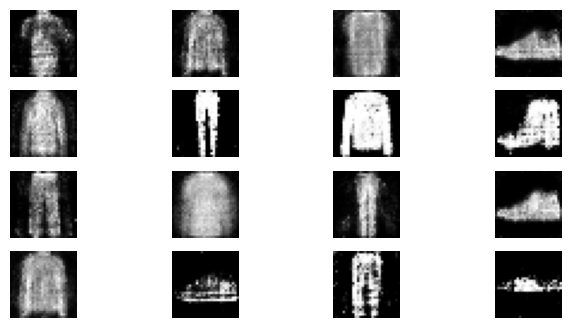

 92%|█████████▏| 46/50 [08:18<00:42, 10.66s/it]

Time for epoch 46 is 10.675644874572754 sec
Training started with epochs 47 with 469 bateches...
Losses after epoch    47: generator 2.221, discriminator 0.686,  real_score 81.10%, fake_score 21.12%


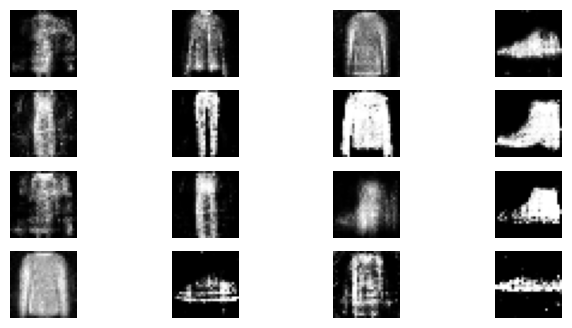

 94%|█████████▍| 47/50 [08:31<00:34, 11.37s/it]

Time for epoch 47 is 13.040146350860596 sec
Training started with epochs 48 with 469 bateches...
Losses after epoch    48: generator 2.225, discriminator 0.583,  real_score 77.20%, fake_score 19.55%


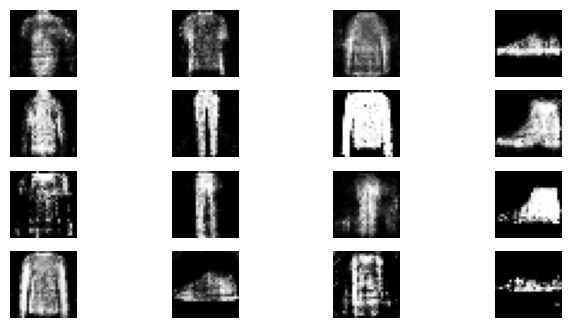

 96%|█████████▌| 48/50 [08:41<00:22, 11.15s/it]

Time for epoch 48 is 10.627279043197632 sec
Training started with epochs 49 with 469 bateches...
Losses after epoch    49: generator 1.456, discriminator 0.935,  real_score 73.27%, fake_score 31.41%


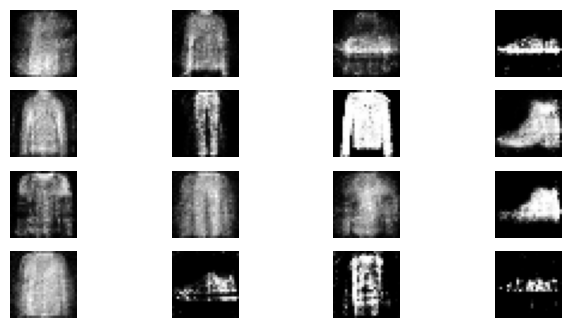

 98%|█████████▊| 49/50 [08:52<00:11, 11.10s/it]

Time for epoch 49 is 10.990376710891724 sec
Training started with epochs 50 with 469 bateches...
Losses after epoch    50: generator 1.840, discriminator 1.068,  real_score 65.57%, fake_score 25.47%


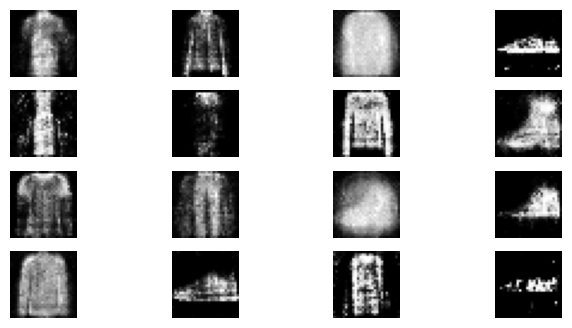

100%|██████████| 50/50 [09:04<00:00, 10.88s/it]

Time for epoch 50 is 11.350677251815796 sec


In [238]:
# start training process
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list=train(train_dataset,epochs=epochs)

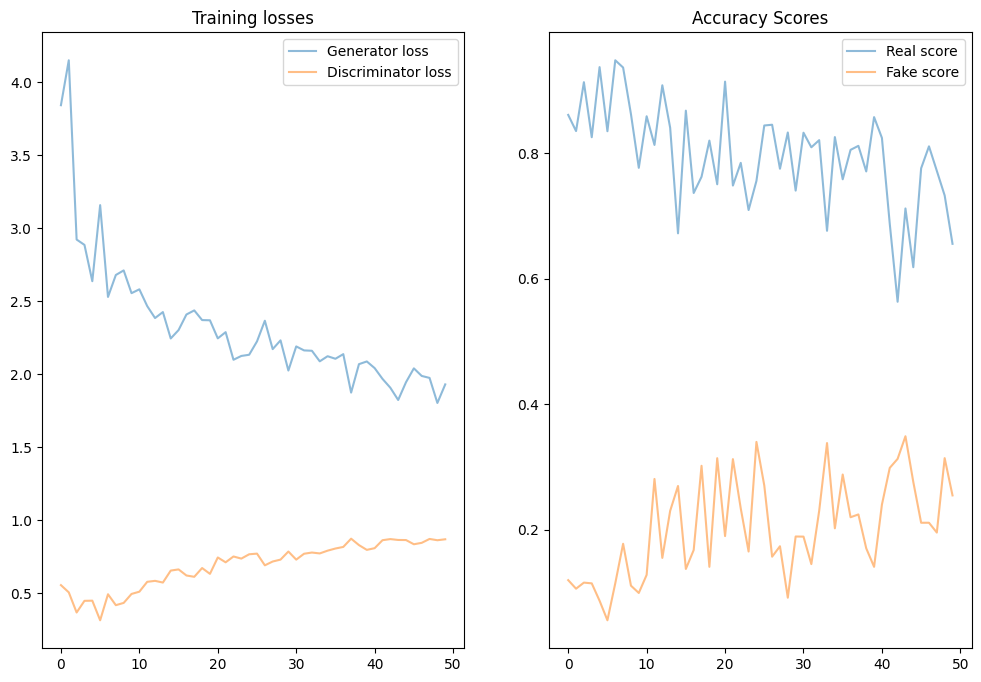

In [240]:
# generated images from the generator improves over time
# discriminator performance becomes worse over time (its loss increases over time)
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

ax1.plot(gen_loss_epochs, label='Generator loss', alpha=0.5)
ax1.plot(disc_loss_epochs, label='Discriminator loss', alpha=0.5)
ax1.set_title('Training losses')
ax1.legend()

ax2.plot(real_score_list, label='Real score',alpha=0.5)
ax2.plot(fake_score_list, label='Fake score',alpha=0.5)
ax2.set_title('Accuracy Scores')
ax2.legend()